# Competition 04 - The Bakery Delivery Route

Management Science - Artisan Bakery

# Client Briefing: Artisan Bakery

## The Morning Delivery Crisis

*“Every morning at 5 AM, our delivery van leaves with fresh bread for 16
cafés across the city. Our driver currently takes much too long using
his ‘intuition’ for the route. The fuel costs are killing us, and worse,
some cafés get their bread late.*

*Three of our premium clients open early at 6:30 AM and absolutely MUST
have their bread by then. The others open at 8:00 AM or later. We’re
spending way too much daily in excess fuel and labor costs.*

*Can you optimize our morning delivery route? We need a solution that
handles our early-bird cafés and minimizes total distance. Help us
deliver happiness more efficiently!“*

## The Challenge

### Business Context

-   **Current situation:** driver’s intuition, frequent late deliveries
-   **Cost structure:**
    -   Fuel: €1.80 per km
    -   Driver: €35 per hour
    -   Late penalty: €50 per late delivery (damages reputation)
-   **Vehicle:** One delivery van, 20 km/h average speed in morning
    traffic
-   **Service Time:** 2 minutes at each café

## Data & Starter Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta

# DON'T MODIFY THIS DATA 
np.random.seed(2025)

# Bakery location (city center)
bakery_location = (3.0, 1.0)

# Generate 16 café locations randomly in a 10x10 km area
cafe_locations = []
for i in range(16):
    x = np.random.uniform(0.5, 9.5)
    y = np.random.uniform(0.5, 9.5)
    cafe_locations.append((x, y))

# Café names and opening times
cafe_info = pd.DataFrame({
    'cafe_id': range(1, 17),
    'name': [
        'Sunrise Bistro', 'The Daily Grind', 'Café Europa', 'Corner Coffee',
        'South Side Café', 'West End Espresso', 'Riverside Roast', 'Morning Glory',
        'Hilltop Haven', 'Central Perk', 'Midtown Munch', 'Old Town Oven',
        'Eastside Express', 'Downtown Deli', 'Westpark Café', 'Plaza Perks'
    ],
    'x': [loc[0] for loc in cafe_locations],
    'y': [loc[1] for loc in cafe_locations],
    'opening_time': [
        '06:30', '08:00', '06:30', '08:00',  # Cafés 1-4
        '08:00', '08:00', '08:00', '06:30',  # Cafés 5-8
        '08:00', '08:00', '08:00', '08:00',  # Cafés 9-12
        '08:00', '08:00', '08:00', '08:00'   # Cafés 13-16
    ],
    'time_window': [
        'EARLY', 'Regular', 'EARLY', 'Regular',  # Cafés 1-4
        'Regular', 'Regular', 'Regular', 'EARLY',  # Cafés 5-8
        'Regular', 'Regular', 'Regular', 'Regular',  # Cafés 9-12
        'Regular', 'Regular', 'Regular', 'Regular'   # Cafés 13-16
    ]
})

# Display the café information
print("CAFÉ INFORMATION:")
print("=" * 60)
print(cafe_info.to_string(index=False))
print("\n" + "=" * 60)
print(f"Bakery location: {bakery_location}")
print(f"Departure time: 5:00 AM")
print(f"Average speed: 40 km/h")
print("\nEARLY cafés (must arrive before opening):")
for _, row in cafe_info[cafe_info['time_window'] == 'EARLY'].iterrows():
    print(f"  - {row['name']} (Café {row['cafe_id']}): Opens at {row['opening_time']}")
# DON'T MODIFY THIS DATA 

CAFÉ INFORMATION:
 cafe_id              name        x        y opening_time time_window
       1    Sunrise Bistro 1.719393 8.490665        06:30       EARLY
       2   The Daily Grind 8.893451 4.510113        08:00     Regular
       3       Café Europa 3.994120 2.818368        06:30       EARLY
       4     Corner Coffee 6.416308 4.933552        08:00     Regular
       5   South Side Café 9.178146 7.708860        08:00     Regular
       6 West End Espresso 4.596848 7.709523        08:00     Regular
       7   Riverside Roast 0.875462 7.425121        08:00     Regular
       8     Morning Glory 0.528540 3.135285        06:30       EARLY
       9     Hilltop Haven 5.998229 8.717247        08:00     Regular
      10      Central Perk 3.201035 2.737388        08:00     Regular
      11     Midtown Munch 6.497529 9.387796        08:00     Regular
      12     Old Town Oven 4.714434 1.609586        08:00     Regular
      13  Eastside Express 8.744282 9.015292        08:00     Regular
  

## Starter Code & Helper Functions

In [2]:
def calculate_distance(point1, point2):
    """Calculate Euclidean distance between two points."""
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def create_distance_matrix(bakery_loc, cafe_locs):
    """Create a distance matrix for all locations."""
    all_locations = [bakery_loc] + cafe_locs
    n = len(all_locations)
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                distances[i][j] = calculate_distance(all_locations[i], all_locations[j])

    return distances

def calculate_route_distance(route, distance_matrix):
    """
    Calculate total distance for a route (returns to start).
    
    Args:
        route: List of café indices in visit order (1-16)
        distance_matrix: Distance matrix (17x17, index 0 is bakery)
    
    Returns:
        Total distance in km
    """
    total = distance_matrix[0][route[0]]  # Bakery to first café
    for i in range(len(route) - 1):
        total += distance_matrix[route[i]][route[i+1]]  # Between cafés
    total += distance_matrix[route[-1]][0]  # Last café back to bakery
    return total

def calculate_arrival_times(route, distance_matrix, start_time="05:00", speed_kmh=20):
    """Calculate arrival time at each café."""
    arrivals = []
    current_time = datetime.strptime(start_time, "%H:%M")

    # Time to first café
    travel_minutes = (distance_matrix[0][route[0]] / speed_kmh) * 60
    current_time += timedelta(minutes=travel_minutes)
    arrivals.append(current_time.strftime("%H:%M"))

    # Time between cafés
    for i in range(len(route) - 1):
        travel_minutes = (distance_matrix[route[i]][route[i+1]] / speed_kmh) * 60
        current_time += timedelta(minutes=travel_minutes + 2)  # 2 min service time
        arrivals.append(current_time.strftime("%H:%M"))

    return arrivals

def check_time_windows(route, distance_matrix, cafe_info):
    """Check if route meets time window constraints."""
    arrivals = calculate_arrival_times(route, distance_matrix)
    violations = []

    for i, cafe_idx in enumerate(route):
        cafe = cafe_info.iloc[cafe_idx - 1]
        arrival = arrivals[i]
        opening = cafe['opening_time']

        if cafe['time_window'] == 'EARLY' and arrival > opening:
            violations.append({
                'cafe': cafe['name'],
                'arrival': arrival,
                'opening': opening,
                'late_by': (datetime.strptime(arrival, "%H:%M") -
                          datetime.strptime(opening, "%H:%M")).seconds // 60
            })

    return violations

# Create distance matrix
distance_matrix = create_distance_matrix(bakery_location, cafe_locations)
print("\nDistance matrix created. Ready to optimize!")


Distance matrix created. Ready to optimize!

## Visualization Function

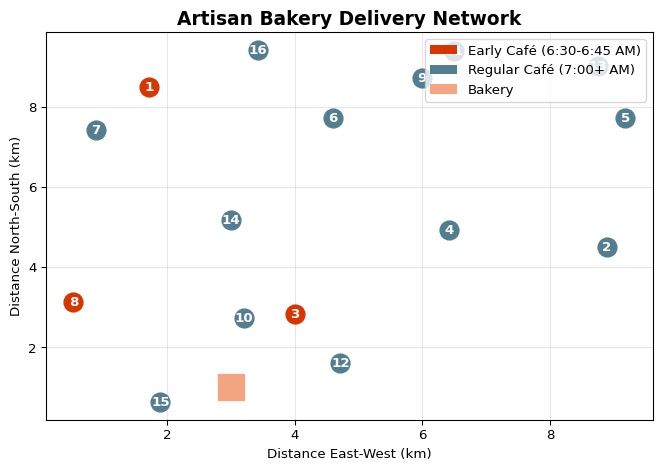

In [3]:
def visualize_route(route, cafe_info, bakery_loc, title="Delivery Route"):
    """Visualize the delivery route on a map."""
    plt.figure()

    # Plot cafés
    for _, cafe in cafe_info.iterrows():
        color = '#D73502' if cafe['time_window'] == 'EARLY' else '#537E8F'
        plt.scatter(cafe['x'], cafe['y'], s=200, c=color, zorder=3)
        plt.annotate(f"{cafe['cafe_id']}", (cafe['x'], cafe['y']),
                    ha='center', va='center', color='white', fontweight='bold')

    # Plot bakery
    plt.scatter(bakery_loc[0], bakery_loc[1], s=400, c='#F4A582',
               marker='s', zorder=3, label='Bakery')

    # Plot route if provided
    if route:
        route_x = [bakery_loc[0]]
        route_y = [bakery_loc[1]]
        for cafe_id in route:
            cafe = cafe_info.iloc[cafe_id - 1]
            route_x.append(cafe['x'])
            route_y.append(cafe['y'])
        route_x.append(bakery_loc[0])
        route_y.append(bakery_loc[1])

        plt.plot(route_x, route_y, 'o-', color='gray', linewidth=2,
                markersize=0, alpha=0.6)

        # Add route order annotations
        for i, cafe_id in enumerate(route, 1):
            cafe = cafe_info.iloc[cafe_id - 1]
            plt.annotate(f"#{i}", (cafe['x'], cafe['y']),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=8, color='black')

    plt.xlabel('Distance East-West (km)')
    plt.ylabel('Distance North-South (km)')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#D73502', label='Early Café (6:30-6:45 AM)'),
        Patch(facecolor='#537E8F', label='Regular Café (7:00+ AM)'),
        Patch(facecolor='#F4A582', label='Bakery')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# Show the initial problem
visualize_route([], cafe_info, bakery_location, "Artisan Bakery Delivery Network")

## Your Task

In the lecture, you learned that **optimization problems** can be solved
using local search by defining four components:

1.  **Search Space:** All possible routes visiting 16 cafés
2.  **Initial Solution:** Your construction algorithm creates a starting
    route
3.  **Objective Function:** Total distance traveled (minimize this!)
4.  **Neighborhood:** How to create “nearby” solutions (2-opt swaps,
    Or-opt moves, etc.)

Your task is to implement these components for the bakery delivery
problem.

> **Important**
>
> -   Ensure early cafés are visited before their opening times
> -   You may need to modify your algorithm to prioritize these
> -   Use the provided `check_time_windows()` function to verify
>     feasibility

> **Tip**
>
> If time windows are too difficult for you, ignore them and just
> optimized the route. You will have to pay some penalty then, but it is
> potentially still better than the current route based on the drivers
> intuition.

## Step 1: Initial Solution

Try one or multiple approaches to create your initial solution.

In [4]:
# YOUR SOLUTION HERE

## Step 2: Apply Local Search

Use one or multiple local search algorithms to improve your initial
solution.

In [5]:
# YOUR SOLUTION HERE

## Step 3: Visualize Your Best Solution

In [6]:
# YOUR SOLUTION HERE

## Step 4: Compute the financial impact

In [7]:
# YOUR SOLUTION HERE

## Step 5: Create Your Submission

Prepare a one-slide presentation (PDF) containing:

-   **Your Best Route:** Total cost (potentially compared to random
    route)
-   **Approach:** Which initial construction and local search methods
    did you use?
-   **Map:** Visual showing routes (optional but recommended)
-   **Strategy Justification:** 2-3 sentences explaining why your
    approach works

## Tips for Success

### Strategy Suggestions

1.  **Quick Win:** Start with nearest neighbor, it’s simple and often
    good enough
    -   You practiced this in the tutorial with Bean Counter’s 10
        franchises
2.  **Time Windows First:** Consider visiting early cafés first, even if
    slightly suboptimal
    -   The lecture showed how to modify construction algorithms for
        time constraints
3.  **Improvement Focus:** Even basic 2-opt can save 10-20% distance
    -   Remember to check feasibility after each swap
4.  **Validation:** Always check time windows!
    -   Use `check_time_windows()` to verify your solution

### Common Pitfalls to Avoid

-   Forgetting to return to bakery
-   Not checking time windows until the end
-   Over-optimizing distance at the expense of deadlines
-   Starting from a café instead of the bakery

### Hints from the Baker

*“The early bird cafés are my premium clients. I’d rather drive an extra
kilometer than be late to them!”*

*“My current driver always does the early cafés first, then figures out
the rest. Maybe he’s onto something?”*

*“Sometimes the ‘shortest’ route isn’t the best route when you factor in
traffic patterns and delivery windows.”*

## Final Checklist

Before presenting your solution, verify:

-   [ ] All 16 cafés visited exactly once
-   [ ] Route starts and ends at the bakery
-   [ ] Early cafés (1, 3, 8) arrive before their opening times (if
    possible!)
-   [ ] No time window violations reported by `check_time_windows()`
-   [ ] Route distance calculated correctly (includes return to bakery)
-   [ ] Improvement shown from initial to final solution
-   [ ] One-slide presentation ready with visualization and metrics

## Good Luck!